In [1]:
# Set the first GPU as visible
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
import cv2
import sys
import torch
import numpy as np

sys.path.append('/home/sebastian.cavada/scsv/thesis/mast3r_mine')
import mast3r.utils.path_to_dust3r  # noqa

from dust3r.inference import inference
from dust3r.model import AsymmetricCroCo3DStereo
from dust3r.utils.image import load_images
from dust3r.image_pairs import make_pairs
from dust3r.cloud_opt import global_aligner, GlobalAlignerMode

from mast3r.model import AsymmetricMASt3R
%matplotlib inline

import matplotlib.pyplot as plt
import imageio.v2 as imageio

import torch
import torch.nn.functional as F

import os
import json

import numpy as np
from pathlib import Path

import sys
import imageio.v2 as imageio
import matplotlib.pyplot as plt

from typing import Set
sys.path.append('/home/sebastian.cavada/scsv/thesis/mast3r_mine/dust3r')

from dust3r.utils.geometry import depthmap_to_pts3d, depthmap_to_camera_coordinates, depthmap_to_absolute_camera_coordinates # nofq
import dust3r.datasets.utils.cropping as cropping

# Specify the folder containing JSON files
folder_path = './arkitscenes_pairs/Training'

file_name = folder_path + "/scene_list.json"
print(file_name)

with open(file_name, 'r') as file:
    scene_list = json.load(file)

    # print(scene_list)

gt_path = Path('/data3/sebastian.cavada/datasets/arkitscenes_test/Training')

/home/sebastian.cavada/scsv/thesis/mast3r_mine/dust3r/dust3r/cloud_opt/base_opt.py:275: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


./arkitscenes_pairs/Training/scene_list.json


In [3]:
scene_list.index('47334185')

69

/data3/sebastian.cavada/datasets/arkitscenes_test/Training/47334185/vga_wide/47334185_354503.582.jpg /data3/sebastian.cavada/datasets/arkitscenes_test/Training/47334185/vga_wide/47334185_354510.479.jpg


/home/sebastian.cavada/micromamba/envs/mast3r/lib/python3.11/site-packages/imageio/plugins/pillow.py:320: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(


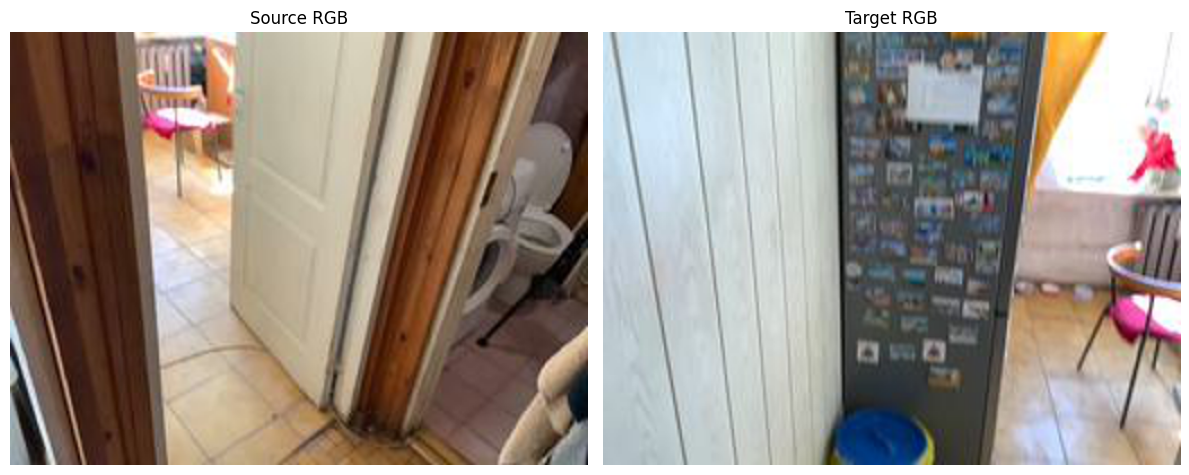

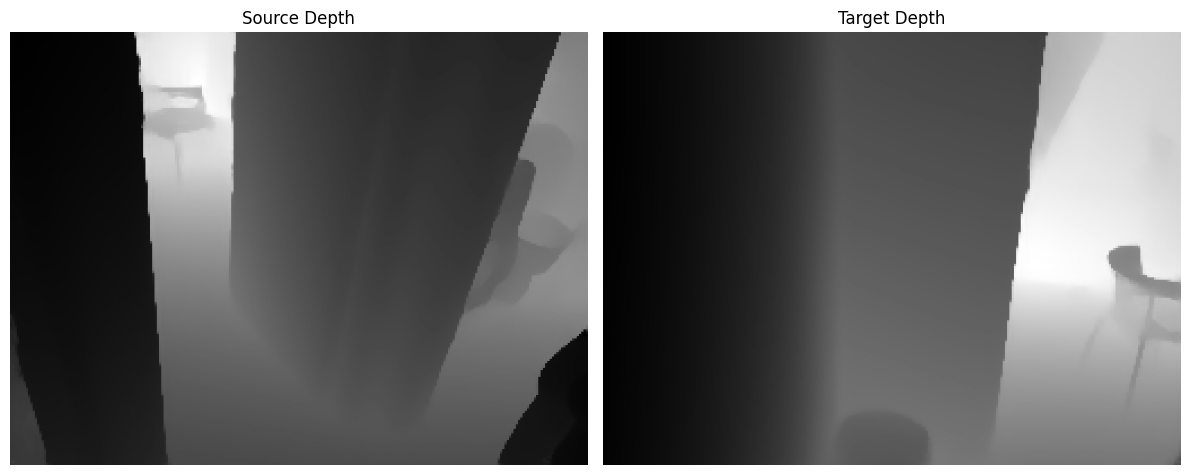

here 11
here 64
(384, 512, 3)
(384, 512, 3)


In [4]:
np.random.seed(42)

for scene in scene_list[69:70]:    
    scene_path = Path(folder_path) / scene / "selected_pairs.npz"
    # print(scene_path)
    data = np.load(scene_path, allow_pickle=True)  # allow_pickle=True is optional; depends on the file content.
    # print(data)
    # print(len(data['selection']))        

    # the common elements are all in the gt_data
    # common_elements = list(set(data['selection']) & set(gt_data['images']))
    # # intersection = [item for item in data['selection'] if item in gt_data['images']]
    # print(len(common_elements))

    gt_file_path = gt_path / scene / "scene_metadata.npz"
    gt_data = np.load(gt_file_path, allow_pickle=True)
    selected_indexes = np.random.randint(0, len(gt_data['pairs']), 100)

    # print(gt_data['pairs'][423210])

    selected_pairs = gt_data['pairs'][selected_indexes]    
    # print(len(gt_data['images']))    
    # print(len(gt_data['intrinsics']))
    # print(len(selected_pairs))

    # okay here then we need to convert depth maps to 3D point cloudsss HOW boh vediamo pomeriggio
    print

    # for i, pair in enumerate(selected_pairs):
    #     if gt_data['images'][int(pair[0])] == '47334185_354503.582.png':
    #         print(gt_data['images'][int(pair[0])])        
    #         print("index", i)

    for pair in selected_pairs[46:47]:        

        # print(gt_data['trajectories'][int(pair[0])] )
        
        src_depth = gt_data['images'][int(pair[0])] 
        target_depth = gt_data['images'][int(pair[1])]

        src_depth_path = gt_path / scene / "lowres_depth" / src_depth
        target_depth_path = gt_path / scene / "lowres_depth" / target_depth        

        src_rgb_path = gt_path / scene / "vga_wide" / src_depth.replace('.png', '.jpg')
        target_rgb_path = gt_path / scene / "vga_wide" / target_depth.replace('.png', '.jpg')

        print(src_rgb_path, target_rgb_path)

        src_depth_image = imageio.imread(src_depth_path)
        target_depth_image = imageio.imread(target_depth_path)

        # print("HEYY", target_depth_path) 

        src_rgb_image = imageio.imread(src_rgb_path)
        target_rgb_image = imageio.imread(target_rgb_path)

        # print(src_rgb_image)
        # print(target_rgb_path)

        fx, fy, cx, cy = gt_data['intrinsics'][int(pair[0])][2:]
        camera_intrinsics = np.eye(3)
        camera_intrinsics[0,0] = fx
        camera_intrinsics[1,1] = fy
        camera_intrinsics[0,2] = cx
        camera_intrinsics[1,2] = cy        
         
        target_resolution = (512, 384)
        src_rgb_image, src_depth_image, intrinsics = cropping.rescale_image_depthmap(src_rgb_image, src_depth_image, camera_intrinsics, target_resolution)
        target_rgb_image, target_depth_image, intrinsics = cropping.rescale_image_depthmap(target_rgb_image, target_depth_image, camera_intrinsics, target_resolution)

        # intrinsics = camera_intrinsics 
        # print(intrinsics)
        # print(src_rgb_image, target_rgb_image)

        # Create a figure with two subplots side by side
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Display the source depth image
        axes[0].imshow(src_rgb_image)  # Use 'gray' colormap for depth maps
        axes[0].set_title('Source RGB')
        axes[0].axis('off')  # Hide axis

        # Display the target depth image
        axes[1].imshow(target_rgb_image)
        axes[1].set_title('Target RGB')
        axes[1].axis('off')

        # Adjust layout and display
        plt.tight_layout()
        plt.show()

        # Create a figure with two subplots side by side
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Display the source depth image
        axes[0].imshow(src_depth_image, cmap='gray')  # Use 'gray' colormap for depth maps
        axes[0].set_title('Source Depth')
        axes[0].axis('off')  # Hide axis

        # Display the target depth image
        axes[1].imshow(target_depth_image, cmap='gray')
        axes[1].set_title('Target Depth')
        axes[1].axis('off')

        # Adjust layout and display
        plt.tight_layout()
        plt.show()

        # print(type(src_depth_image))
        # print(gt_data['intrinsics'])         
        print("here", int(pair[0])) 
        camera_extrinsics_img1 = gt_data['trajectories'][int(pair[0])]
        print("here", int(pair[1])) 
        camera_extrinsics_img2 = gt_data['trajectories'][int(pair[1])] 
        
        # pts3d_img1, valid_mask_img1 = depthmap_to_absolute_camera_coordinates(src_depth_image, intrinsics, camera_extrinsics_img1)
        # pts3d_img2, valid_mask_img2 = depthmap_to_absolute_camera_coordinates(target_depth_image, intrinsics, camera_extrinsics_img2)

        pts3d_img1, valid_mask_img1 = depthmap_to_camera_coordinates(src_depth_image, intrinsics)
        pts3d_img2, valid_mask_img2 = depthmap_to_camera_coordinates(target_depth_image, intrinsics)

        # X_cam, valid_mask = depthmap_to_camera_coordinates(src_depth_image, camera_intrinsics)
        print(pts3d_img1.shape)
        print(pts3d_img2.shape)

                

In [5]:
intrinsics

array([[423.89800212,   0.        , 256.366     ],
       [  0.        , 423.89800212, 192.3666    ],
       [  0.        ,   0.        ,   1.        ]])

In [6]:
camera_extrinsics_img1

array([[-0.00447814, -0.53430494,  0.84527994,  0.25813778],
       [-0.99502903, -0.08171314, -0.0569227 ,  0.09428441],
       [ 0.09948456, -0.84133298, -0.53128301, -0.1407484 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [7]:
camera_extrinsics_img2

array([[ 0.75678697, -0.22418587,  0.6140148 ,  1.25740722],
       [-0.65330597, -0.29039489,  0.69918675,  0.11481099],
       [ 0.02155897, -0.93027496, -0.36622903, -0.12707904],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [43]:
R1 = camera_extrinsics_img1[:3, :3]
t1 = camera_extrinsics_img1[:3, 3]

R2 = camera_extrinsics_img2[:3, :3]
t2 = camera_extrinsics_img2[:3, 3]

R_rel = R2 @ R1.T
t_rel = t2 - R_rel @ t1

In [28]:
import numpy as np
import cv2

def get_relative_transform(extrinsics1, extrinsics2):
    """
    Compute the relative transform from camera 1 to camera 2
    Makes camera 1 the origin and expresses camera 2's position relative to it
    
    Returns:
    - R: relative rotation matrix (3x3)
    - t: relative translation vector (3,)
    """
    R1 = extrinsics1[:3, :3]
    t1 = extrinsics1[:3, 3]

    R2 = extrinsics2[:3, :3]
    t2 = extrinsics2[:3, 3]

    # Relative rotation
    R_rel = R2.T @ R1

    # Relative translation
    t_rel = R2.T @ (t1 - t2)

    # R_rel = R2 @ R1.T
    # t_rel = t2 - R_rel @ t1

    # # Convert world-to-camera transforms to camera-to-world
    # R_rel = extrinsics2[:3, :3] @ extrinsics1[:3, :3].T
    
    # t_rel = extrinsics2[:3, 3] - R_rel @ extrinsics1[:3, 3]        
    
    return R_rel, t_rel

R_rel, t_rel = get_relative_transform(extrinsics1=camera_extrinsics_img1, extrinsics2=camera_extrinsics_img2)
# R_rel = camera_extrinsics_img2[:3, :3].T 
# t_rel = camera_extrinsics_img2[:3, 3]
print(R_rel)
print(t_rel)

R1 = camera_extrinsics_img1[:3, :3]
t1 = camera_extrinsics_img1[:3, 3]

R2 = R1 @ R_rel
t2 = R1 @ t_rel + t1

print("=====")
print(R2)
print(t2)

print(camera_extrinsics_img2[:3, :3])
print(camera_extrinsics_img2[:3, 3])

[[ 0.64881419 -0.36910961  0.66543087]
 [ 0.19740728  0.92618371  0.32126953]
 [-0.7348949  -0.07708333  0.67378606]]
[-0.74311865  0.24269916 -0.62291201]
=====
[[-0.72957308 -0.5583686   0.39490205]
 [-0.61988752  0.29598118 -0.7267287 ]
 [ 0.28889891 -0.77499655 -0.56206563]]
[-0.39474481  0.84933517 -0.08792547]
[[ 0.75678697 -0.22418587  0.6140148 ]
 [-0.65330597 -0.29039489  0.69918675]
 [ 0.02155897 -0.93027496 -0.36622903]]
[ 1.25740722  0.11481099 -0.12707904]


In [44]:
def get_essential_matrix(R, t):
    """
    Compute essential matrix from relative rotation and translation
    """
    t = t / np.linalg.norm(t)

    # Create skew-symmetric matrix from translation
    t_cross = np.array([
        [0, -t[2], t[1]],
        [t[2], 0, -t[0]],
        [-t[1], t[0], 0]
    ])
    
    # Compute essential matrix
    E = t_cross @ R
    return E

E = get_essential_matrix(R_rel, t_rel)
print(E)

[[ 0.00214155  0.01357235 -0.14580319]
 [-0.20965523 -0.04517841 -0.9664457 ]
 [ 0.83084663  0.5183436  -0.19887871]]


In [45]:
def compute_fundamental_matrix(K1, K2, E):
    """
    Compute fundamental matrix from essential matrix and intrinsics
    F = K2^(-T) * E * K1^(-1)
    """
    F = np.linalg.inv(K2.T) @ E @ np.linalg.inv(K1)

    F = F / F[2,2]

    return F

K1 = camera_intrinsics
K2 = camera_intrinsics
# print(K1)
MYF = compute_fundamental_matrix(K1, K2, E)
print(MYF)

[[-1.01086904e-07 -6.40650238e-07  1.53308698e-03]
 [ 9.89627540e-06  2.13253920e-06  8.19821022e-03]
 [-9.24869458e-03 -5.30841444e-03  1.00000000e+00]]


In [46]:
def compute_epipolar_line_essential(E, point):
    """
    Compute epipolar line in second image for point in first image
    point: [x, y] in pixels
    Returns line coefficients [a, b, c] where ax + by + c = 0
    """
    # Convert point to homogeneous coordinates
    point_normalized = np.linalg.inv(K1) @ np.array([point[0], point[1], 1])
    
    # Compute epipolar line
    line_normalized = E @ point_normalized
    line = np.linalg.inv(K2).T @ line_normalized

    return line

def compute_epipolar_line(F, point):
    """
    Compute epipolar line in second image for point in first image
    point: [x, y] in pixels
    Returns line coefficients [a, b, c] where ax + by + c = 0
    """
    # Convert point to homogeneous coordinates
    point_normalized = np.array([point[0], point[1], 1])
    
    # Compute epipolar line
    line = F @ point_normalized    

    return line

point = [150,150]
line = compute_epipolar_line(MYF, point)
print(line)


[ 0.00142183  0.01000253 -1.18356635]


In [47]:
def draw_epipolar_line(img, line, color=(0, 255, 0), thickness=2):
    """
    Draw epipolar line on image
    line: [a, b, c] where ax + by + c = 0
    """
    height, width = img.shape[:2]
    
    # Find intersection points with image borders
    # At x=0
    if abs(line[1]) > 1e-6:
        y0 = int(-line[2] / line[1])
        # At x=width
        y1 = int(-(line[2] + line[0] * width) / line[1])
    else:
        y0 = 0
        y1 = height - 1
                
    # Draw line
    pt1 = (0, y0)
    pt2 = (width, y1)
    print(pt1, pt2)
    cv2.line(img, pt1, pt2, color, thickness)
    return img

# Draw epipolar line on source image
target_rgb_image_np = np.array(target_rgb_image)
src_rgb_epipolar = draw_epipolar_line(target_rgb_image_np.copy(), line)

(0, 118) (512, 45)


In [57]:
test_F = MYF.copy()
multiply = np.array([[1, 1, 1], [1, -1, -1], [1, 1, 1]])

test_F = test_F * multiply
print(test_F)

[[-1.01086904e-07 -6.40650238e-07  1.53308698e-03]
 [ 9.89627540e-06 -2.13253920e-06 -8.19821022e-03]
 [-9.24869458e-03 -5.30841444e-03  1.00000000e+00]]


In [58]:
def visualize_epipolar_geometry(img1, img2, F, point1, point2=None):
    """
    Visualize epipolar geometry
    - Draw point in image 1
    - Draw epipolar line in image 2
    - If point2 is provided, draw it and compute epipolar constraint error
    """
    # Create copies for drawing
    img1_draw = img1.copy()
    img2_draw = img2.copy()
    
    # Draw point in image 1
    cv2.circle(img1_draw, (int(point1[0]), int(point1[1])), 5, (0, 255, 0), -1)
    
    # Compute and draw epipolar line in image 2
    line = compute_epipolar_line(F, point1)
    print(line)
    img2_draw = draw_epipolar_line(img2_draw, line, color=(0, 255, 0))
    
    if point2 is not None:
        # Draw corresponding point in image 2
        print(point2)
        cv2.circle(img2_draw, (int(point2[0]), int(point2[1])), 5, (255, 0, 0), -1)
        
        # Check epipolar constraint
        x1 = np.array([point1[0], point1[1], 1])
        x2 = np.array([point2[0], point2[1], 1])
        F = F / np.linalg.norm(F)
        error = abs(x2.T @ F @ x1)
        print(f"Epipolar constraint error: {error:.2e}")
        
        # Compute distance from point2 to epipolar line
        # line is normalized so that distance = |ax + by + c|/sqrt(a^2 + b^2)
        line_norm = np.sqrt(line[0]**2 + line[1]**2)
        distance = abs(line[0]*point2[0] + line[1]*point2[1] + line[2]) / line_norm
        print(f"Distance from point to epipolar line: {distance:.2f} pixels")
    
    return img1_draw, img2_draw

point1 = [150, 150]
point2 = [460, 350]

src_rgb_image_np = np.array(src_rgb_image)
target_rgb_image_np = np.array(target_rgb_image)

img1_draw, img2_draw = visualize_epipolar_geometry(src_rgb_image_np, target_rgb_image_np, test_F, point1, point2)




[ 0.00142183 -0.00703365 -1.18356635]
(0, -168) (512, -64)
[460, 350]
Epipolar constraint error: 2.99e+00
Distance from point to epipolar line: 416.85 pixels


(np.float64(-0.5), np.float64(511.5), np.float64(383.5), np.float64(-0.5))

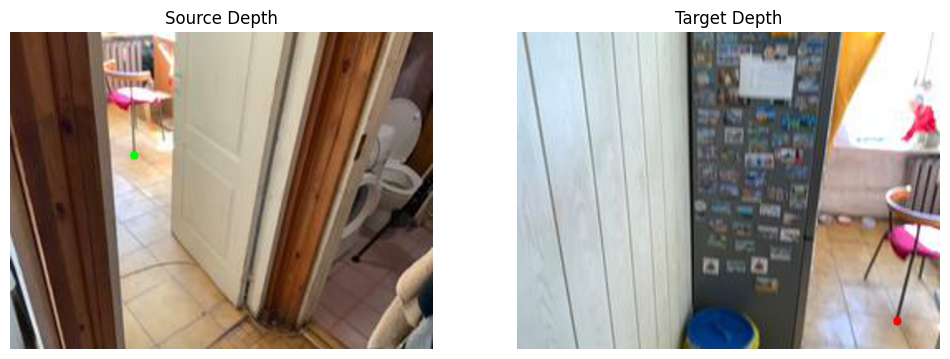

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the source depth image
axes[0].imshow(img1_draw, cmap='gray')  # Use 'gray' colormap for depth maps
axes[0].set_title('Source Depth')
axes[0].axis('off')  # Hide axis

# Display the target depth image
axes[1].imshow(img2_draw, cmap='gray')
axes[1].set_title('Target Depth')
axes[1].axis('off')

In [108]:
pts1 = np.array([
    (150, 150),
    (145, 84),
    (161, 84),
    (137, 93),
    (114, 52),
    (122, 74),
    (123, 35),
    (149, 114),
    (127, 126),
])

pts2 = np.array([
    (460, 350),
    (481, 267),
    (502, 269),
    (466, 273),
    (449, 211),
    (452, 243),
    (473, 187),
    (471, 303),
    (447, 309),
])

# Reshape points to (N, 1, 2)
pts1_reshaped = pts1.reshape(-1, 1, 2)
pts2_reshaped = pts2.reshape(-1, 1, 2)

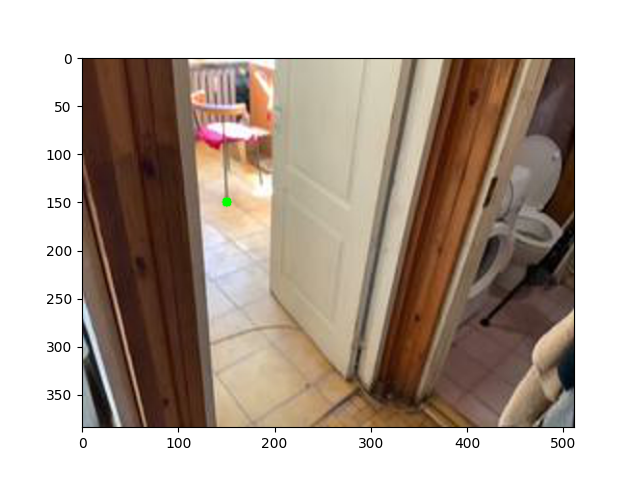

In [76]:
%matplotlib ipympl

import matplotlib.pyplot as plt
import numpy as np

# Create a random image

# Display the image
fig, ax = plt.subplots()
ax.imshow(img1_draw, cmap='gray')

# Define the click event function
def on_click(event):
    if event.inaxes:  # Check if the click is inside the axes
        x, y = int(event.xdata), int(event.ydata)
        print(f"Clicked at: ({x}, {y})")

# Connect the click event to the function
cid = fig.canvas.mpl_connect('button_press_event', on_click)

plt.show()


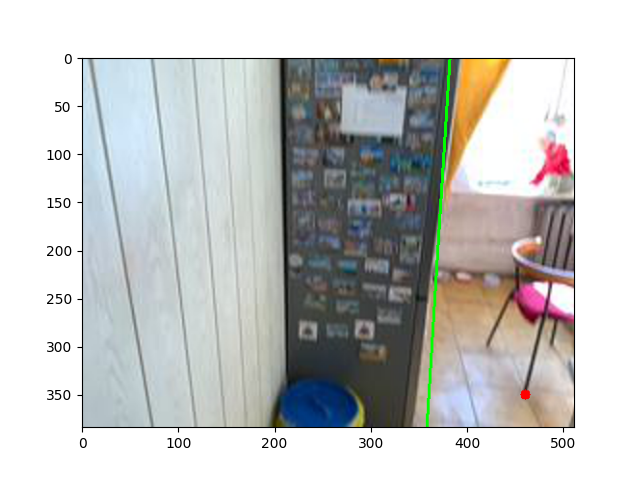

In [77]:
%matplotlib ipympl

import matplotlib.pyplot as plt
import numpy as np

# Create a random image

# Display the image
fig, ax = plt.subplots()
ax.imshow(img2_draw, cmap='gray')

# Define the click event function
def on_click(event):
    if event.inaxes:  # Check if the click is inside the axes
        x, y = int(event.xdata), int(event.ydata)
        print(f"Clicked at: ({x}, {y})")

# Connect the click event to the function
cid = fig.canvas.mpl_connect('button_press_event', on_click)

plt.show()


In [50]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

img1 = src_rgb_image_np
img2 = target_rgb_image_np

sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
pts1 = []
pts2 = []
# # ratio test as per Lowe's paper
# for i,(m,n) in enumerate(matches):
#     if m.distance < 0.8*n.distance:
#         pts2.append(kp2[m.trainIdx].pt)
#         pts1.append(kp1[m.queryIdx].pt)

In [51]:
pts1 = [
    (150, 150),
    (145, 84),
    (161, 84),
    (137, 93),
    (114, 52),
    (122, 74),
    (123, 35),
    (149, 114),
    (127, 126),
]

pts2 = [
    (460, 350),
    (481, 267),
    (502, 269),
    (466, 273),
    (449, 211),
    (452, 243),
    (473, 187),
    (471, 303),
    (447, 309),
]

In [52]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)
print(F)
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

[[-7.92576795e-06  3.62442880e-05  1.68299953e-03]
 [ 1.51735784e-05 -1.81570079e-05 -1.11087362e-02]
 [-1.63538727e-03  3.23847783e-03  1.00000000e+00]]


In [53]:
def drawlinesaa(img1,img2,lines,pts1,pts2):        
    r,c,_ = img1.shape    
    # img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    # img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)    
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)    
    return img1,img2

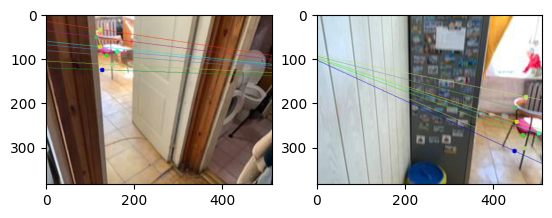

In [54]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)

img5, img6 = drawlinesaa(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlinesaa(img2,img1,lines2,pts2,pts1)
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

In [55]:
print(F)
print(MYF)

[[-7.92576795e-06  3.62442880e-05  1.68299953e-03]
 [ 1.51735784e-05 -1.81570079e-05 -1.11087362e-02]
 [-1.63538727e-03  3.23847783e-03  1.00000000e+00]]
[[-1.01086904e-07 -6.40650238e-07  1.53308698e-03]
 [ 9.89627540e-06  2.13253920e-06  8.19821022e-03]
 [-9.24869458e-03 -5.30841444e-03  1.00000000e+00]]


[[ 0.64881419  0.19740728 -0.7348949 ]
 [-0.36910961  0.92618371 -0.07708333]
 [ 0.66543087  0.32126953  0.67378606]]
[-0.02353952 -0.54709237  0.83623168]
=====
[[ 0.75678697 -0.22418587  0.6140148 ]
 [-0.65330597 -0.29039489  0.69918675]
 [ 0.02155897 -0.93027496 -0.36622903]]
[ 1.25740722  0.11481099 -0.12707904]
[[ 0.75678697 -0.22418587  0.6140148 ]
 [-0.65330597 -0.29039489  0.69918675]
 [ 0.02155897 -0.93027496 -0.36622903]]
[ 1.25740722  0.11481099 -0.12707904]
[[-0.05541463 -0.95067353 -0.30429341]
 [ 0.55846097  0.17271438 -0.59893712]
 [ 0.36380504  0.08623486 -0.40041158]]
[[ 4.16418599e-06  7.14392843e-05 -2.53962755e-03]
 [-4.19660912e-05 -1.29787894e-05  1.61532853e-02]
 [-2.30115530e-03 -9.26781628e-03  1.00000000e+00]]
[ 0.00880089  0.00791155 -0.73534574]
(0, 92) (512, -476)
[ 0.00880089  0.00791155 -0.73534574]
(0, 92) (512, -476)
[460, 350]
Epipolar constraint error: 6.08e+00
Distance from point to epipolar line: 513.94 pixels


(np.float64(-0.5), np.float64(511.5), np.float64(383.5), np.float64(-0.5))

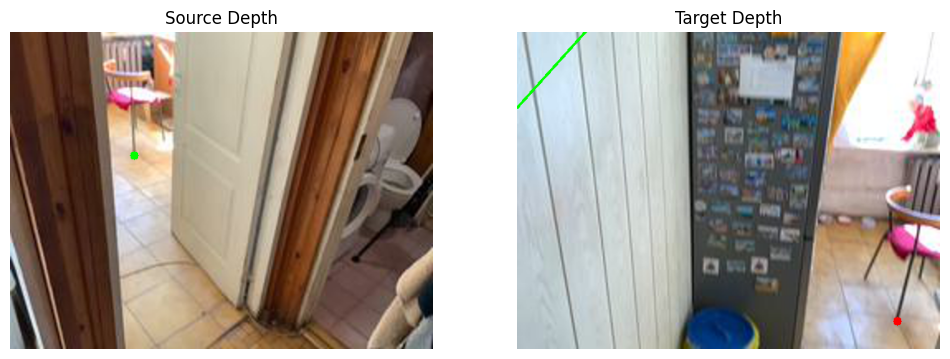

In [30]:
import numpy as np
import cv2

def get_relative_transform(extrinsics1, extrinsics2):
    """
    Compute the relative transform from camera 1 to camera 2
    Makes camera 1 the origin and expresses camera 2's position relative to it
    
    Returns:
    - R: relative rotation matrix (3x3)
    - t: relative translation vector (3,)
    """
    R1 = extrinsics1[:3, :3]
    t1 = extrinsics1[:3, 3]

    R2 = extrinsics2[:3, :3]
    t2 = extrinsics2[:3, 3]

    # Relative rotation
    R_rel = R1.T @ R2
    # Relative translation    
    t_rel = R1.T @ (t2 - t1)    

    # R_rel = R2 @ R1.T
    # t_rel = t2 - R_rel @ t1

    # # Convert world-to-camera transforms to camera-to-world
    # R_rel = extrinsics2[:3, :3] @ extrinsics1[:3, :3].T
    
    # t_rel = extrinsics2[:3, 3] - R_rel @ extrinsics1[:3, 3]        
    
    return R_rel, t_rel

R_rel, t_rel = get_relative_transform(extrinsics1=camera_extrinsics_img1, extrinsics2=camera_extrinsics_img2)
# R_rel = camera_extrinsics_img2[:3, :3].T 
# t_rel = camera_extrinsics_img2[:3, 3]
print(R_rel)
print(t_rel)

R1 = camera_extrinsics_img1[:3, :3]
t1 = camera_extrinsics_img1[:3, 3]

R2 = R1 @ R_rel
t2 = R1 @ t_rel + t1

print("=====")
print(R2)
print(t2)

print(camera_extrinsics_img2[:3, :3])
print(camera_extrinsics_img2[:3, 3])


def get_essential_matrix(R, t):
    """
    Compute essential matrix from relative rotation and translation
    """
    t = t / np.linalg.norm(t)

    # Create skew-symmetric matrix from translation
    t_cross = np.array([
        [0, -t[2], t[1]],
        [t[2], 0, -t[0]],
        [-t[1], t[0], 0]
    ])
    
    # Compute essential matrix
    E = t_cross @ R
    return E

E = get_essential_matrix(R_rel, t_rel)
print(E)

def compute_fundamental_matrix(K1, K2, E):
    """
    Compute fundamental matrix from essential matrix and intrinsics
    F = K2^(-T) * E * K1^(-1)
    """
    F = np.linalg.inv(K2.T) @ E @ np.linalg.inv(K1)

    F = F / F[2,2]

    return F

K1 = camera_intrinsics
K2 = camera_intrinsics
# print(K1)
F = compute_fundamental_matrix(K1, K2, E)
print(F)

def compute_epipolar_line(F, point):
    """
    Compute epipolar line in second image for point in first image
    point: [x, y] in pixels
    Returns line coefficients [a, b, c] where ax + by + c = 0
    """
    # Convert point to homogeneous coordinates
    point_normalized = np.array([point[0], point[1], 1])
    
    # Compute epipolar line
    line = F @ point_normalized    

    return line

point = [150,150]
line = compute_epipolar_line(F, point)
print(line)

def draw_epipolar_line(img, line, color=(0, 255, 0), thickness=2):
    """
    Draw epipolar line on image
    line: [a, b, c] where ax + by + c = 0
    """
    height, width = img.shape[:2]
    
    # Find intersection points with image borders
    # At x=0
    if abs(line[1]) > 1e-6:
        y0 = int(-line[2] / line[1])
        # At x=width
        y1 = int(-(line[2] + line[0] * width) / line[1])
    else:
        y0 = 0
        y1 = height - 1
                
    # Draw line
    pt1 = (0, y0)
    pt2 = (width, y1)
    print(pt1, pt2)
    cv2.line(img, pt1, pt2, color, thickness)
    return img

# Draw epipolar line on source image
target_rgb_image_np = np.array(target_rgb_image)
src_rgb_epipolar = draw_epipolar_line(target_rgb_image_np.copy(), line)

def visualize_epipolar_geometry(img1, img2, F, point1, point2=None):
    """
    Visualize epipolar geometry
    - Draw point in image 1
    - Draw epipolar line in image 2
    - If point2 is provided, draw it and compute epipolar constraint error
    """
    # Create copies for drawing
    img1_draw = img1.copy()
    img2_draw = img2.copy()
    
    # Draw point in image 1
    cv2.circle(img1_draw, (int(point1[0]), int(point1[1])), 5, (0, 255, 0), -1)
    
    # Compute and draw epipolar line in image 2
    line = compute_epipolar_line(F, point1)
    print(line)
    img2_draw = draw_epipolar_line(img2_draw, line, color=(0, 255, 0))
    
    if point2 is not None:
        # Draw corresponding point in image 2
        print(point2)
        cv2.circle(img2_draw, (int(point2[0]), int(point2[1])), 5, (255, 0, 0), -1)
        
        # Check epipolar constraint
        x1 = np.array([point1[0], point1[1], 1])
        x2 = np.array([point2[0], point2[1], 1])
        F = F / np.linalg.norm(F)
        error = abs(x2.T @ F @ x1)
        print(f"Epipolar constraint error: {error:.2e}")
        
        # Compute distance from point2 to epipolar line
        # line is normalized so that distance = |ax + by + c|/sqrt(a^2 + b^2)
        line_norm = np.sqrt(line[0]**2 + line[1]**2)
        distance = abs(line[0]*point2[0] + line[1]*point2[1] + line[2]) / line_norm
        print(f"Distance from point to epipolar line: {distance:.2f} pixels")
    
    return img1_draw, img2_draw

point1 = [150, 150]
point2 = [460, 350]

src_rgb_image_np = np.array(src_rgb_image)
target_rgb_image_np = np.array(target_rgb_image)

img1_draw, img2_draw = visualize_epipolar_geometry(src_rgb_image_np, target_rgb_image_np, F, point1, point2)


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the source depth image
axes[0].imshow(img1_draw, cmap='gray')  # Use 'gray' colormap for depth maps
axes[0].set_title('Source Depth')
axes[0].axis('off')  # Hide axis

# Display the target depth image
axes[1].imshow(img2_draw, cmap='gray')
axes[1].set_title('Target Depth')
axes[1].axis('off')
